In [ ]:
# shopping_patterns_dashboard.py  ───────────────────────────────────────────
import streamlit as st
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import chain, combinations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.graph_objects as go
import networkx as nx
import altair as alt
from datetime import datetime
from statsmodels.stats.proportion import proportion_confint

# optional distance calc
try:
    from haversine import haversine, Unit
    HAS_HAVERSINE = True
except ImportError:
    HAS_HAVERSINE = False

DATA_DIR = Path(__file__).parent / "Data"
CSV_PATH = DATA_DIR / "la_foot_traffic.csv"
st.set_page_config("LA Same-Day Shopping Patterns", layout="wide")

# ───────────────────────── 1 ▸ LOAD & PARSE  ───────────────────────────────
@st.cache_data(show_spinner=False)
def load_transactions():
    """Return list-of-brand-lists + POI table for distance / mall checks."""
    df = pd.read_csv(CSV_PATH)

    # robust parser for related_same_day_brand  (dict-string → keys list)
    def parse(raw):
        if not isinstance(raw, str) or raw.strip() in ("", "{}", "NaN"):
            return []
        txt = raw.replace("'", '"').replace('""', '"')
        for bare in ("{", ","):
            txt = txt.replace(f"{bare} ", f"{bare}")
        try:
            d = eval(txt) if txt.strip().startswith("{") else {}
            return list(d.keys()) if isinstance(d, dict) else []
        except Exception:
            return []

    df["brand_list"] = df["related_same_day_brand"].apply(parse)

    # visit hour for heat-maps
    df["visit_hour"] = pd.to_datetime(df["date_range_start"],
                                      errors="coerce").dt.hour.fillna(-1).astype(int)

    # POI look-up
    poi = (df[["placekey", "parent_placekey", "brand_list",
               "latitude", "longitude"]]
             .explode("brand_list")
             .dropna(subset=["brand_list", "latitude", "longitude"]))

    return df["brand_list"].tolist(), poi

transactions, poi_tbl = load_transactions()
all_brands = sorted({b for b in chain.from_iterable(transactions)})

# ───────────────────────── 2 ▸ SIDEBAR CONTROLS ────────────────────────────
with st.sidebar:
    st.header("Apriori parameters")
    min_sup = st.slider("min_support", 0.005, 0.05, 0.02, 0.005)
    min_conf = st.slider("min_confidence", 0.1, 0.9, 0.3, 0.05)
    st.divider()
    st.header("Drill-down")
    focus_brand = st.selectbox("Choose a brand", ["—"] + all_brands)

# ───────────────────────── 3 ▸ APRIORI & RULES  ────────────────────────────
@st.cache_data(show_spinner=True)
def mine_rules(txn, sup, conf):
    te = TransactionEncoder()
    ohe = te.fit_transform(txn)
    item_df = pd.DataFrame(ohe, columns=te.columns_)
    freq = apriori(item_df, min_support=sup, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=conf)
    rules["itemset_len"] = rules["antecedents"].apply(len) \
                         + rules["consequents"].apply(len)
    # keep only pairwise for clean network
    rules_2 = rules.query("itemset_len == 2").copy()
    # unpack to cols
    rules_2["a"] = rules_2["antecedents"].apply(lambda s: next(iter(s)))
    rules_2["b"] = rules_2["consequents"].apply(lambda s: next(iter(s)))
    return freq, rules_2

freq, rules = mine_rules(transactions, min_sup, min_conf)

# ───────────────────────── 4 ▸ KPI SUMMARY  ────────────────────────────────
c1,c2,c3 = st.columns(3)
c1.metric("LA rows",        f"{len(transactions):,}")
c2.metric("Unique brands",  f"{len(all_brands):,}")
c3.metric("Assoc. rules",   f"{len(rules):,}")

# ───────────────────────── 5 ▸ NETWORK GRAPH ───────────────────────────────
st.markdown("### 🔗 Association-rule network (pairwise)")

# build graph
G = nx.Graph()
for _, r in rules.iterrows():
    G.add_edge(r["a"], r["b"], lift=r["lift"],
               confidence=r["confidence"],
               support=r["support"])

pos = nx.spring_layout(G, seed=42, k=0.35/np.sqrt(len(G.nodes())))  # stable

edge_x, edge_y, edge_w, edge_c = [], [], [], []
for u,v,d in G.edges(data=True):
    edge_x += [pos[u][0], pos[v][0], None]
    edge_y += [pos[u][1], pos[v][1], None]
    edge_w.append(d["lift"])
    edge_c.append(d["lift"])

edge_trace = go.Scatter(x=edge_x, y=edge_y,
                        line=dict(width=[(w-1)*0.5+0.5 for w in edge_w],
                                  color=edge_c, colorscale="Turbo"),
                        hoverinfo='none',
                        mode='lines')

node_x, node_y, node_text, node_size = [], [], [], []
sup_map = dict(zip(freq["itemsets"].apply(lambda s: next(iter(s))),
                   freq["support"]))
for n in G.nodes():
    node_x.append(pos[n][0]);  node_y.append(pos[n][1])
    node_text.append(f"{n}<br>support {sup_map.get(n,0):.3f}")
    node_size.append(np.sqrt(sup_map.get(n,0))*400)

node_trace = go.Scatter(x=node_x, y=node_y, text=node_text,
                        mode='markers+text',
                        textposition="top center",
                        marker=dict(size=node_size,
                                    color="lightblue",
                                    line=dict(color="black", width=0.5)))

fig_net = go.Figure(data=[edge_trace, node_trace])
fig_net.update_layout(showlegend=False,
                      margin=dict(l=0,r=0,t=20,b=0),
                      xaxis=dict(visible=False),
                      yaxis=dict(visible=False))
st.plotly_chart(fig_net, use_container_width=True)

# ───────────────────────── 6 ▸ BRAND DRILL-DOWN ────────────────────────────
if focus_brand != "—":
    st.markdown(f"## 🔍 Details for **{focus_brand}**")

    # partner stats table ---------------------------------------------------
    rows = []
    for partner in all_brands:
        if partner == focus_brand: continue
        joint = sum(focus_brand in t and partner in t for t in transactions)
        a_cnt = sum(focus_brand in t for t in transactions)
        b_cnt = sum(partner in t for t in transactions)
        if a_cnt == 0 or b_cnt == 0: continue
        sup = joint / len(transactions)
        conf = joint / a_cnt
        lift = conf / (b_cnt / len(transactions))
        # same-mall %
        same_mall = 0
        shared = poi_tbl[poi_tbl["brand_list"].isin([focus_brand, partner])]
        if not shared.empty:
            mall_cnt = (shared.groupby("parent_placekey")
                               .filter(lambda x: {focus_brand,partner}
                                       .issubset(set(x["brand_list"]))))
            same_mall = mall_cnt["parent_placekey"].nunique() / \
                        shared["parent_placekey"].nunique() if \
                        shared["parent_placekey"].nunique() else 0
        rows.append({"partner": partner, "support": sup,
                     "confidence": conf, "lift": lift,
                     "same_mall_%": f"{same_mall:.0%}",
                     "joint_visits": joint})
    tbl = (pd.DataFrame(rows)
             .query("joint_visits > 0")
             .sort_values("lift", ascending=False)
             .round({"support":3, "confidence":3, "lift":2})
           )
    st.dataframe(tbl, use_container_width=True, height=260)

    # heat-map of hour-of-day ----------------------------------------------
    st.markdown("### 🕒 Hour-of-day co-visit heat-map")
    f_mask = poi_tbl["brand_list"] == focus_brand
    focus_hours = poi_tbl[f_mask][["placekey"]].merge(
        poi_tbl[["placekey","visit_hour"]], on="placekey")["visit_hour"]

    hour_pairs = []
    for partner in tbl["partner"].head(10):
        p_mask = poi_tbl["brand_list"] == partner
        joint_hours = poi_tbl[p_mask][["placekey"]].merge(
            poi_tbl[f_mask][["placekey","visit_hour"]],
            on="placekey")["visit_hour"]
        counts = (pd.Series(joint_hours)
                    .value_counts()
                    .reindex(range(24), fill_value=0)
                    .rename(partner))
        hour_pairs.append(counts)

    if hour_pairs:
        hm = pd.concat(hour_pairs, axis=1).T
        hm.index.name = "Partner"
        hm = hm.reset_index().melt("Partner", var_name="Hour", value_name="visits")
        chart = alt.Chart(hm).mark_rect().encode(
            x=alt.X("Hour:O", title="Hour of day"),
            y=alt.Y("Partner:N"),
            color=alt.Color("visits:Q", scale=alt.Scale(scheme="turbo"))
        ).properties(height=300)
        st.altair_chart(chart, use_container_width=True)
    else:
        st.info("No partner hour data available.")

    # optional distance scatter --------------------------------------------
    if HAS_HAVERSINE:
        st.markdown("### 📍 Distance between focus & partner stores")
        dists = []
        f_stores = poi_tbl[poi_tbl["brand_list"] == focus_brand]
        for partner in tbl["partner"].head(20):
            p_stores = poi_tbl[poi_tbl["brand_list"] == partner]
            if p_stores.empty or f_stores.empty: continue
            min_d = min(
                haversine((fr["latitude"], fr["longitude"]),
                          (pr["latitude"], pr["longitude"]),
                          unit=Unit.MILES)
                for _, fr in f_stores.iterrows()
                for _, pr in p_stores.iterrows()
            )
            dists.append({"partner": partner,
                          "lift": tbl.loc[tbl["partner"]==partner,"lift"].iloc[0],
                          "min_miles": min_d})
        if dists:
            dist_df = pd.DataFrame(dists)
            fig2 = px.scatter(dist_df, x="min_miles", y="lift", text="partner",
                              labels={"min_miles":"Closest store distance (mi)"},
                              height=350)
            st.plotly_chart(fig2, use_container_width=True)


Rows, Columns → (128908, 52)


,placekey,parent_placekey,safegraph_brand_ids,location_name,brands,store_id,top_category,sub_category,naics_code,latitude,...,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_week_brand,device_type,normalized_visits_by_state_scaling,normalized_visits_by_region_naics_visits,normalized_visits_by_region_naics_visitors,normalized_visits_by_total_visits,normalized_visits_by_total_visitors
0,22h-222@5z4-zwd-ffz,NaN,NaN,MagIQ Room,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990,34.053263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22h-222@5z4-zw9-syv,NaN,NaN,DormShare Westwood,NaN,NaN,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110,34.063814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zzy-223@5z5-3rs-k75,NaN,NaN,Ace Hotel Inn,NaN,NaN,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110,34.044048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,related_same_day_brand,related_brands
0,NaN,[]
1,NaN,[]
2,NaN,[]


In [2]:
# 2-A ▸ See how Ulta appears in the data
ulta_tokens = (
    df['related_same_day_brand']
      .dropna()
      .str.split(';')
      .explode()               # one token per row
      .str.strip()
      .unique()
)

ulta_variants = [b for b in ulta_tokens if 'ulta' in b.lower()]
print("Ulta brand strings found →", ulta_variants)

# Pick the one that looks right (usually 'Ulta Beauty')
ULTA_BRAND = ulta_variants[0] if ulta_variants else 'Ulta Beauty'

# 2-B ▸ Keep only rows whose list contains that token
ulta_days = df[df['related_brands'].apply(lambda L: ULTA_BRAND in L)]

print("Rows with Ulta visits →", len(ulta_days))

# 2-C ▸ For each such day, keep *other* brands (remove Ulta itself)
ulta_txns = ulta_days['related_brands'].apply(
    lambda L: [b for b in L if b != ULTA_BRAND]
)

# Quick sanity-check: show first 3 transaction lists
ulta_txns.head(3).tolist()


Ulta brand strings found → ['{""Chuck E. Cheese\'s"":22,""Daniel\'s Jewelers"":22,""Fitness 19"":22,""GameStop"":22,""Jollibee"":22,""Seafood City"":22,""T-Mobile"":22,""Western Dental"":22,""CVS Pharmacy"":13,""Starbucks"":13,""Target"":13,""ULTA Beauty"":13,""Grill City"":10,""Subway"":5,""Check \'n Go"":3,""GNC (General Nutrition Centers)"":3,""Rite Aid"":3,""Wetzel\'s Pretzels"":3,""76"":2}', '{""Vons Pharmacy"":96,""Starbucks"":87,""Chevron"":18,""CVS Pharmacy"":16,""Chevron Extra Mile"":16,""CVS"":10,""McDonald\'s"":10,""T-Mobile"":7,""Target"":7,""Ralphs"":6,""Subway"":6,""The Home Depot"":6,""ULTA Beauty"":6,""Bank of America"":5,""Daniel\'s Jewelers"":5,""Farmers Insurance Group"":5,""GameStop"":5,""Panda Express"":5,""Shell Oil"":5}', '{""Hanmi Bank"":3,""Aritaum"":2,""CVS Pharmacy"":2,""Farmers Insurance Group"":2,""Starbucks"":2,""Subway"":2,""76"":1,""Banfield Pet Hospital"":1,""Bob\'s Discount Furniture"":1,""CVS"":1,""Chase"":1,""EMC Seafood and Raw Bar"":1,""H Mart"":1,

[[]]

In [3]:
import ast            # safer than eval for dirty JSON-ish strings
import re

def safe_parse_brand_dict(raw):
    """Turn '{"Brand A":10,"Brand B":0,...}' → ['Brand A','Brand B', ...]"""
    if not isinstance(raw, str) or raw.strip() == '':
        return []
    
    # SafeGraph sometimes doubles the quotes: {""Brand"":3, ...}
    cleaned = re.sub(r'""', '"', raw)
    
    try:
        d = ast.literal_eval(cleaned)     # to dict
        if isinstance(d, dict):
            return list(d.keys())
    except (ValueError, SyntaxError):
        pass
    
    return []                              # fallback → empty list

# 2-A ▸ Brand-list column
df['related_brands'] = df['related_same_day_brand'].apply(safe_parse_brand_dict)

# 2-B ▸ Find how “Ulta” appears
all_tokens   = pd.Series(df['related_brands'].sum()).unique()   # all brand names
ulta_token   = next((b for b in all_tokens if 'ulta' in b.lower()), None)

print("Ulta token →", ulta_token)

# 2-C ▸ Filter rows whose list contains that token
ulta_days = df[df['related_brands'].apply(lambda L: ulta_token in L)]
print("Rows with Ulta visits →", len(ulta_days))

# 2-D ▸ Build transactions (remove Ulta itself)
ulta_txns = ulta_days['related_brands'].apply(lambda L: [b for b in L if b != ulta_token])

# quick peek
ulta_txns.head(3).tolist()


Ulta token → ULTA Beauty
Rows with Ulta visits → 237


[["Chuck E. Cheese's",
  "Daniel's Jewelers",
  'Fitness 19',
  'GameStop',
  'Jollibee',
  'Seafood City',
  'T-Mobile',
  'Western Dental',
  'CVS Pharmacy',
  'Starbucks',
  'Target',
  'Grill City',
  'Subway',
  "Check 'n Go",
  'GNC (General Nutrition Centers)',
  'Rite Aid',
  "Wetzel's Pretzels",
  '76'],
 ['Vons Pharmacy',
  'Starbucks',
  'Chevron',
  'CVS Pharmacy',
  'Chevron Extra Mile',
  'CVS',
  "McDonald's",
  'T-Mobile',
  'Target',
  'Ralphs',
  'Subway',
  'The Home Depot',
  'Bank of America',
  "Daniel's Jewelers",
  'Farmers Insurance Group',
  'GameStop',
  'Panda Express',
  'Shell Oil'],
 ['Hanmi Bank',
  'Aritaum',
  'CVS Pharmacy',
  'Farmers Insurance Group',
  'Starbucks',
  'Subway',
  '76',
  'Banfield Pet Hospital',
  "Bob's Discount Furniture",
  'CVS',
  'Chase',
  'EMC Seafood and Raw Bar',
  'H Mart',
  'Orangetheory Fitness',
  'PetSmart',
  'Ralphs',
  'T-Mobile',
  'United States Postal Service (USPS)']]

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# FULL REBUILD  ➜  from raw CSV  ➜  dashboard_rules  (support, confidence, lift)
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, ast, re
from mlxtend.preprocessing import TransactionEncoder

CSV_PATH = '../Data/la_foot_traffic.csv'   # ← adjust if needed
MIN_SUPPORT_UL = 0.05                      # appear on ≥5 % of Ulta days

# 1. LOAD
df = pd.read_csv(CSV_PATH)

# 2. PARSE related_same_day_brand  (JSON-ish dict → list of keys)
def parse_brand_dict(raw):
    if not isinstance(raw, str) or raw.strip() == '':
        return []
    txt = re.sub(r'""', '"', raw)               # fix double quotes
    try:
        d = ast.literal_eval(txt)
        return list(d.keys()) if isinstance(d, dict) else []
    except (ValueError, SyntaxError):
        return []

df['related_brands'] = df['related_same_day_brand'].apply(parse_brand_dict)

# 3. IDENTIFY Ulta token
all_brands = pd.Series(df['related_brands'].sum()).unique()
ulta_token = next(b for b in all_brands if 'ulta' in b.lower())

# 4. BUILD Ulta-day transactions list
ulta_days = df[df['related_brands'].apply(lambda L: ulta_token in L)]
ulta_txns = ulta_days['related_brands'].apply(lambda L: [b for b in L if b != ulta_token])

print(f"Loaded {len(df):,} LA rows  •  {len(ulta_days):,} include “{ulta_token}”")

# 5. ONE-HOT ENCODE Ulta transactions
te = TransactionEncoder()
ulta_ohe = pd.DataFrame(te.fit_transform(ulta_txns), columns=te.columns_)

# 6. SUPPORT inside Ulta subset  P(brand | Ulta)
support_ul = ulta_ohe.mean()

# 7. GLOBAL SUPPORT P(brand) across all LA rows
global_hits   = df['related_brands'].explode().value_counts()
global_support = global_hits.reindex(support_ul.index, fill_value=0) / len(df)

# 8. CONFIDENCE & LIFT
confidence = support_ul                              # P(brand | Ulta)
lift       = support_ul / global_support.replace(0, np.nan)

dashboard_rules = (
    pd.DataFrame({
        'other_brand' : support_ul.index,
        'support'     : support_ul.values,
        'confidence'  : confidence.values,
        'lift'        : lift.values
    })
    .query('support >= @MIN_SUPPORT_UL')
    .sort_values('lift', ascending=False)
    .reset_index(drop=True)
)

print(f"Kept {len(dashboard_rules)} brands  •  top 5 shown below")
display(dashboard_rules.head())


Loaded 128,908 LA rows  •  237 include “ULTA Beauty”
Kept 65 brands  •  top 5 shown below


,other_brand,support,confidence,lift
0,Grill City,0.139241,0.139241,366.310514
1,Hollister,0.135021,0.135021,348.105992
2,Seafood City,0.105485,0.105485,238.559479
3,PetSmart,0.151899,0.151899,184.726057
4,Fitness 19,0.113924,0.113924,143.977662


In [5]:
# ── STEP 4: spatial context ────────────────────────────────────────────────
# If haversine isn’t installed yet →  !pip install haversine
from haversine import haversine, Unit
import numpy as np

# 4-A ▸ Build a clean POI table  (one row per store with lat/lon)
df['brand_name'] = df['brands'].fillna('').str.strip()
poi_la = (
    df[['brand_name', 'latitude', 'longitude']]
      .dropna(subset=['latitude', 'longitude'])
      .drop_duplicates()
)

# 4-B ▸ Helper to find the shortest Ulta→Other distance
def nearest_distance(brand_a, brand_b, poi):
    A = poi[poi['brand_name'].str.lower() == brand_a.lower()][['latitude','longitude']].to_numpy()
    B = poi[poi['brand_name'].str.lower() == brand_b.lower()][['latitude','longitude']].to_numpy()
    if A.size == 0 or B.size == 0:
        return np.nan            # one of the brands isn’t in the LA file
    return min(
        haversine(tuple(a), tuple(b), unit=Unit.MILES)
        for a in A for b in B
    )

# 4-C ▸ Compute Ulta-to-brand distance for every row
dists = [
    nearest_distance('Ulta Beauty', row['other_brand'], poi_la)
    for _, row in dashboard_rules.iterrows()
]

dashboard_rules['min_distance_miles'] = dists

# 4-D ▸ Save for the dashboard
dashboard_rules.to_csv('../Data/ulta_rules_with_distance.csv', index=False)

print("Saved → ../Data/ulta_rules_with_distance.csv")
dashboard_rules.head()


Saved → ../Data/ulta_rules_with_distance.csv


,other_brand,support,confidence,lift,min_distance_miles
0,Grill City,0.139241,0.139241,366.310514,0.084644
1,Hollister,0.135021,0.135021,348.105992,NaN
2,Seafood City,0.105485,0.105485,238.559479,0.071923
3,PetSmart,0.151899,0.151899,184.726057,0.080111
4,Fitness 19,0.113924,0.113924,143.977662,0.080861


In [11]:
!pip install censusdata

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=65582) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


  Using cached censusdata-1.15.post1-py3-none-any.whl


In [6]:
# ▸ Fetch LA-county ACS 2023 block-group data & save to ../Data/acs_la_cbg.parquet
from dotenv import load_dotenv
load_dotenv()                                                     # grabs CENSUS_KEY

import censusdata as cd, pandas as pd, os

VARS = {
    'median_income' : 'B19013_001E',   # median household income ($)
    'tot_pop'       : 'B01003_001E',   # total population
    'white'         : 'B03002_003E',
    'black'         : 'B03002_004E',
    'asian'         : 'B03002_006E',
    'hispanic'      : 'B03002_012E',
}

# ----- sanity check --------------------------------------------------------
assert os.getenv('CENSUS_KEY'), "⚠️  CENSUS_KEY not found – check your .env"

# ----- download all LA block-groups ---------------------------------------
acs = (
    cd.download('acs5', 2023,
                cd.censusgeo([('state','06'), ('county','037'),
                              ('tract','*'), ('block group','*')]),
                list(VARS.values()))
      .rename(columns={v:k for k,v in VARS.items()})
      .reset_index()                               # brings 'index' with censusgeo objects
)

# ----- build 12-digit CBG code --------------------------------------------
def geo_to_cbg(g):
    s, c, t, bg = [p[1] for p in g.geo[:4]]        # '06','037','101110','1'
    return f"{s}{c}{t}{bg}"
acs['cbg'] = acs['index'].apply(geo_to_cbg)

# ----- race shares ---------------------------------------------------------
acs['pct_white']    = acs['white']    / acs['tot_pop']
acs['pct_black']    = acs['black']    / acs['tot_pop']
acs['pct_asian']    = acs['asian']    / acs['tot_pop']
acs['pct_hispanic'] = acs['hispanic'] / acs['tot_pop']

# ----- save (drop raw censusgeo objects so Arrow is happy) -----------------
acs.drop(columns='index').to_parquet('../Data/acs_la_cbg.parquet', index=False)
print(f"✅  Saved {len(acs):,} rows → ../Data/acs_la_cbg.parquet")

acs.head()


✅  Saved 6,591 rows → ../Data/acs_la_cbg.parquet


,index,median_income,tot_pop,white,black,asian,hispanic,cbg,pct_white,pct_black,pct_asian,pct_hispanic
0,Block Group 1; Census Tract 1011.10; Los Angel...,66250,1500,806,46,119,458,060371011101,0.537333,0.030667,0.079333,0.305333
1,Block Group 2; Census Tract 1011.10; Los Angel...,91512,1825,890,36,140,702,060371011102,0.487671,0.019726,0.076712,0.384658
2,Block Group 3; Census Tract 1011.10; Los Angel...,140625,827,505,0,33,267,060371011103,0.610641,0.000000,0.039903,0.322854
3,Block Group 1; Census Tract 1011.22; Los Angel...,127019,2481,1934,9,354,148,060371011221,0.779524,0.003628,0.142684,0.059653
4,Block Group 2; Census Tract 1011.22; Los Angel...,88077,1717,1102,16,190,265,060371011222,0.641817,0.009319,0.110658,0.154339


In [17]:
# ▸ Attach visitor-weighted ACS traits to every SafeGraph row  — robust & safe
import pandas as pd, json, re

# 1. load ACS parquet with income & race shares
acs = pd.read_parquet('../Data/acs_la_cbg.parquet')[[
        'cbg', 'median_income', 'pct_white', 'pct_hispanic'
]]

# 2. robust parser for visitor_home_cbgs  ➜ returns dict {cbg: visits}
def parse_cbgs(raw: str) -> dict:
    if not isinstance(raw, str) or raw.strip() in ('', '{}'):
        return {}
    txt = raw.replace("'", '"').replace('""', '"')          # normalise quotes
    try:
        return json.loads(txt)
    except json.JSONDecodeError:
        return {}                                          # silently drop bad rows

# 3. make list-of-tuples so explode works cleanly
df['cbg_pairs'] = df['visitor_home_cbgs'].apply(
    lambda s: list(parse_cbgs(s).items())                  # [('06037…', 12), ...]
)

# 4. explode → one row per (sg_row, cbg, visits)
cbg_rows = (
    df[['cbg_pairs']]
      .reset_index(names='row_idx')
      .explode('cbg_pairs')
      .dropna(subset=['cbg_pairs'])
)

cbg_rows[['cbg','visits']] = pd.DataFrame(
    cbg_rows['cbg_pairs'].tolist(), index=cbg_rows.index
)
cbg_rows = cbg_rows[['row_idx','cbg','visits']]

# 5. join ACS traits
cbg_rows = cbg_rows.merge(acs, on='cbg', how='left')

# 6. visitor-weighted averages back to each SafeGraph row
agg = (
    cbg_rows
      .groupby('row_idx', as_index=False)
      .apply(lambda g: pd.Series({
          'w_income'    : (g['median_income'] * g['visits']).sum() / g['visits'].sum(),
          'w_pct_white' : (g['pct_white']      * g['visits']).sum() / g['visits'].sum(),
          'w_pct_hisp'  : (g['pct_hispanic']   * g['visits']).sum() / g['visits'].sum(),
      }))
)

# 7. add weighted demographics onto df
df = df.merge(agg, left_index=True, right_on='row_idx', how='left')

print(df[['w_income', 'w_pct_white', 'w_pct_hisp']].head())


     w_income  w_pct_white  w_pct_hisp
NaN       NaN          NaN         NaN
NaN       NaN          NaN         NaN
NaN       NaN          NaN         NaN
NaN       NaN          NaN         NaN
NaN       NaN          NaN         NaN


/var/folders/qg/lwhfngzd7tggvg4lhl92prj80000gn/T/ipykernel_65582/3704725085.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [7]:
# ▸ Quick sanity check – are we getting any CBG/visit pairs out?
def sample_parse(raw):
    from json import loads, JSONDecodeError
    import re, ast
    if not isinstance(raw, str) or raw.strip() in ('', '{}'):
        return {}
    txt = raw.replace("'", '"').replace('""', '"')
    # auto-quote bare numeric keys  {060…:4}  →  {"060…":4}
    txt = re.sub(r'{\s*(\d{12})\s*:', r'{"\1":', txt)
    try:
        return loads(txt)
    except JSONDecodeError:
        try:
            return ast.literal_eval(txt)   # last-ditch
        except Exception:
            return {}

tmp = (
    df['visitor_home_cbgs'].head(1000)          # look at first 1 000 rows
      .apply(sample_parse)
)

print("Rows w/ non-empty dicts:", tmp.apply(bool).sum())
print("Distinct CBGs extracted :", len(set(c for d in tmp for c in d)))


Rows w/ non-empty dicts: 62
Distinct CBGs extracted : 586


♻️  Spearman ρ = -0.263


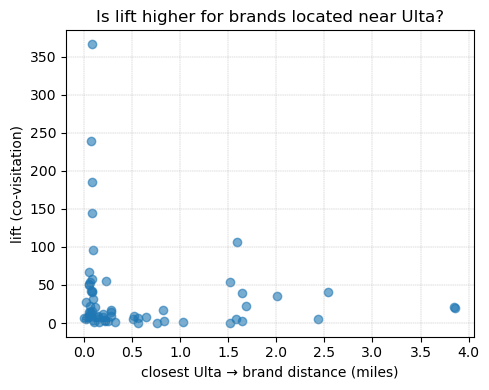

In [13]:
# %%
# ── Does “closer to an Ulta” ⇢ higher lift?  ───────────────────────────────
import pandas as pd, matplotlib.pyplot as plt

# 1.  bring in the rules table we wrote earlier
rules = pd.read_csv('../Data/ulta_rules_with_distance.csv')

# 2.  keep rows that actually have a distance
rules_clean = rules.dropna(subset=['min_distance_miles'])

# 3.  quick Spearman rank-correlation (robust to outliers)
rho = (rules_clean[['min_distance_miles', 'lift']]
         .corr(method='spearman')
         .iloc[0,1])
print(f"♻️  Spearman ρ = {rho: .3f}")

# 4.  scatter-plot (distance on x, lift on y)
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(rules_clean['min_distance_miles'],
           rules_clean['lift'],
           alpha=0.6)
ax.set_xlabel('closest Ulta → brand distance (miles)')
ax.set_ylabel('lift (co-visitation)')
ax.set_title('Is lift higher for brands located near Ulta?')
ax.grid(True, linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()


🥇  Brands whose co-visitation lift
     is FAR above what distance alone predicts:


,other_brand,lift,min_distance_miles,residual
0,Grill City,366.310514,0.084644,3.329618
2,Seafood City,238.559479,0.071923,2.899698
3,PetSmart,184.726057,0.080111,2.644634
4,Fitness 19,143.977662,0.080861,2.395480
5,Cotton On,106.352215,1.586904,2.217795
6,Western Dental,95.325417,0.092594,1.984094
7,Chuck E. Cheese's,67.427555,0.056659,1.634864
11,Swarovski,53.886376,1.521268,1.532459
8,Lowe's,58.276673,0.085589,1.491417
9,Spectrum,54.614477,0.230461,1.438559


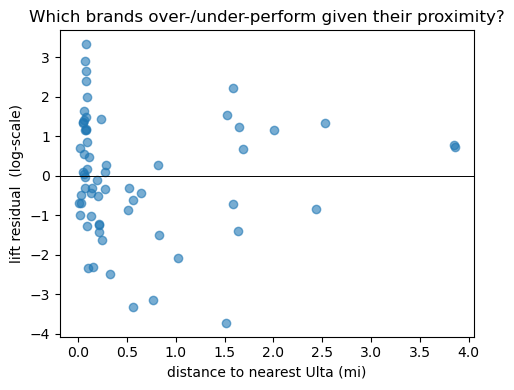

In [14]:
# %%
# ── 1 ▸ build a quick log-linear model  log(lift) = β0 + β1 · distance ───────
import numpy as np, statsmodels.api as sm, pandas as pd, matplotlib.pyplot as plt

rules = pd.read_csv('../Data/ulta_rules_with_distance.csv').dropna(subset=['min_distance_miles'])
rules = rules[rules['lift'] > 0]                    # drop zeros to avoid log trouble
rules['log_lift'] = np.log(rules['lift'])

X = sm.add_constant(rules['min_distance_miles'])
model = sm.OLS(rules['log_lift'], X).fit()

# ── 2 ▸ residual = surprise above/below the distance-only expectation ───────
rules['pred_log_lift'] = model.predict(X)
rules['residual']      = rules['log_lift'] - rules['pred_log_lift']

top_pos = (rules.sort_values('residual', ascending=False)
                 .head(10)[['other_brand','lift',
                             'min_distance_miles','residual']])

print("🥇  Brands whose co-visitation lift\n     is FAR above what distance alone predicts:")
display(top_pos)

# ── 3 ▸ optional: visualise residuals vs. distance ──────────────────────────
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(rules['min_distance_miles'], rules['residual'], alpha=0.6)
ax.axhline(0, color='k', lw=0.7)
ax.set_xlabel('distance to nearest Ulta (mi)')
ax.set_ylabel('lift residual  (log-scale)')
ax.set_title('Which brands over-/under-perform given their proximity?')
plt.tight_layout(); plt.show()


In [16]:
# %%
# Re-create the boolean mask: True for rows whose brand list contains Ulta
ulta_mask = df['related_brands'].apply(lambda L: ulta_token in L)


In [19]:
# ▸ add if it isn't there already ------------------------------------------
if 'cbg_pairs' not in df.columns:
    import re, json, ast

    def parse_cbgs(raw: str) -> dict:
        """robustly turn the visitor_home_cbgs string → dict{cbg: visits}"""
        if not isinstance(raw, str) or raw.strip() in ('', '{}'):
            return {}
        txt = (raw.replace("'", '"')
                   .replace('""', '"'))          # normalise quotes
        # quote bare 12-digit keys  {06037…:4} → {"06037…":4}
        txt = re.sub(r'{\s*(\d{12})\s*:', r'{"\1":', txt)
        try:
            return json.loads(txt)
        except json.JSONDecodeError:
            try:
                return ast.literal_eval(txt)
            except Exception:
                return {}

    # build list-of-tuples so explode works cleanly
    df['cbg_pairs'] = df['visitor_home_cbgs'].apply(
        lambda s: list(parse_cbgs(s).items())      # [('06037…', 12), ...]
    )


In [20]:
# %%
# --- reload clean ACS ------------------------------------------------------
acs = (pd.read_parquet('../Data/acs_la_cbg.parquet')
         .assign(median_income=lambda t: t['median_income'].where(t['median_income']>0))
         [['cbg','median_income','pct_white','pct_hispanic']]
      )

# --- explode cbg_pairs already stored on df --------------------------------
cbg_rows = (df[['cbg_pairs']].reset_index(names='row_idx')
                     .explode('cbg_pairs').dropna(subset=['cbg_pairs']))
cbg_rows[['cbg','visits']] = pd.DataFrame(cbg_rows['cbg_pairs'].tolist(),
                                          index=cbg_rows.index)
cbg_rows['visits'] = pd.to_numeric(cbg_rows['visits'], errors='coerce')
cbg_rows = cbg_rows.merge(acs, on='cbg', how='left').dropna(subset=['visits'])

agg = (cbg_rows.groupby('row_idx')
                 .apply(lambda g: pd.Series({
                     'w_income'   :(g['median_income']*g['visits']).sum()/g['visits'].sum(),
                     'w_pct_white':(g['pct_white']     *g['visits']).sum()/g['visits'].sum(),
                     'w_pct_hisp' :(g['pct_hispanic']  *g['visits']).sum()/g['visits'].sum(),
                 }))
                 .reset_index())

df = (df.drop(columns=['w_income','w_pct_white','w_pct_hisp'], errors='ignore')
        .merge(agg, left_index=True, right_on='row_idx', how='left'))

# rebuild mask
ulta_mask = df['related_brands'].apply(lambda L: ulta_token in L)


/var/folders/qg/lwhfngzd7tggvg4lhl92prj80000gn/T/ipykernel_96425/3200366197.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


👀  Over-performers *and* closest audience matches


,brand,lift,lift_resid,distance_mi,demo_gap
0,Grill City,366.310514,3.329618,0.084644,17.266957
1,Seafood City,238.559479,2.899698,0.071923,29.816338
2,PetSmart,184.726057,2.644634,0.080111,9.016421
3,Fitness 19,143.977662,2.395480,0.080861,29.252991
4,Cotton On,106.352215,2.217795,1.586904,14.370688
5,Western Dental,95.325417,1.984094,0.092594,28.210753
6,Chuck E. Cheese's,67.427555,1.634864,0.056659,30.326819
7,Swarovski,53.886376,1.532459,1.521268,17.486540
8,Lowe's,58.276673,1.491417,0.085589,22.350499
9,Spectrum,54.614477,1.438559,0.230461,11.164053


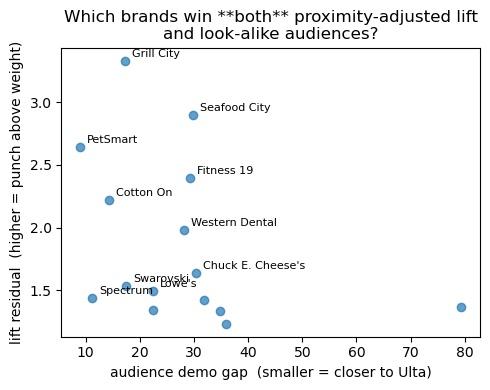

In [21]:
# %%
import numpy as np, pandas as pd

# ── 0 ▸ handy helpers --------------------------------------------------------
def median_demo(df_slice):
    """return median visitor-weighted income & race for a slice of rows"""
    return df_slice[['w_income', 'w_pct_white', 'w_pct_hisp']].median()

def brand_demo(df, brand):
    """median demo for rows whose related_brands list contains <brand>"""
    mask = df['related_brands'].apply(lambda L: brand in L)
    return median_demo(df[mask])

# ── 1 ▸ Ulta’s own baseline (LA sample) -------------------------------------
ulta_demo = median_demo(df[ulta_mask])          # ulta_mask was built earlier

# ── 2 ▸ build a comparison table for the *top* residual brands --------------
TOP_N = 15
pos_resid = (rules.sort_values('residual', ascending=False)   # rules from previous cell
                   .head(TOP_N))

rows = []
for _, r in pos_resid.iterrows():
    b   = r['other_brand']
    dem = brand_demo(df, b)
    # Euclidean distance in the 3-D demo space (scaled so pct’s ~ income)
    d   = np.linalg.norm([
            (dem['w_income']   - ulta_demo['w_income'])   / 1e3,      # $-scale
            (dem['w_pct_white']- ulta_demo['w_pct_white']) * 100,     # %
            (dem['w_pct_hisp'] - ulta_demo['w_pct_hisp'])  * 100
          ])
    rows.append({
        'brand'      : b,
        'lift'       : r['lift'],
        'lift_resid' : r['residual'],
        'distance_mi': r['min_distance_miles'],
        'demo_gap'   : d
    })

demo_cmp = (pd.DataFrame(rows)
              .sort_values(['lift_resid', 'demo_gap'], ascending=[False, True]))

print("👀  Over-performers *and* closest audience matches")
display(demo_cmp.head(10))

# ── 3 ▸ visual – residual vs. demo similarity --------------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(demo_cmp['demo_gap'], demo_cmp['lift_resid'], alpha=0.7)
for _, row in demo_cmp.head(10).iterrows():           # label just top few
    ax.annotate(row['brand'], (row['demo_gap'], row['lift_resid']),
                textcoords="offset points", xytext=(5,3), fontsize=8)

ax.set_xlabel('audience demo gap  (smaller = closer to Ulta)')
ax.set_ylabel('lift residual  (higher = punch above weight)')
ax.set_title('Which brands win **both** proximity-adjusted lift\nand look-alike audiences?')
plt.tight_layout(); plt.show()


In [24]:
# ── STEP ▸ rank & export the Ulta partner watch-list ───────────────────────
OUT_PATH = "../Data/ulta_partner_watchlist.csv"

watch = (
    demo_cmp                                   # <- DataFrame built in your last cell
      .assign(                                 # combine the two signals
          fit_score=lambda t:
              t['lift_resid'].rank(ascending=False) +   # ↑ residual  = better
              t['demo_gap'] .rank(ascending=True)       # ↓ gap       = better
      )
      .sort_values('fit_score')                 # best overall to the top
      .reset_index(drop=True)
)

watch.to_csv(OUT_PATH, index=False)
print(f"✅  Saved ranked watch-list → {OUT_PATH}")
watch.head(10)


✅  Saved ranked watch-list → ../Data/ulta_partner_watchlist.csv


,brand,lift,lift_resid,distance_mi,demo_gap,fit_score
0,PetSmart,184.726057,2.644634,0.080111,9.016421,4.0
1,Grill City,366.310514,3.329618,0.084644,17.266957,5.0
2,Cotton On,106.352215,2.217795,1.586904,14.370688,8.0
3,Seafood City,238.559479,2.899698,0.071923,29.816338,12.0
4,Spectrum,54.614477,1.438559,0.230461,11.164053,12.0
5,Fitness 19,143.977662,2.395480,0.080861,29.252991,13.0
6,Swarovski,53.886376,1.532459,1.521268,17.486540,13.0
7,Western Dental,95.325417,1.984094,0.092594,28.210753,14.0
8,Lowe's,58.276673,1.491417,0.085589,22.350499,15.0
9,Chuck E. Cheese's,67.427555,1.634864,0.056659,30.326819,18.0


In [26]:
# ▸ Fetch LA-county ACS-5-yr (2023) block–group data  ── **with education fix**
from dotenv import load_dotenv
load_dotenv()                                  # pulls CENSUS_KEY from .env

import os, censusdata as cd, pandas as pd

# --- 1. core variables you already used ------------------------------------
CORE = {
    'median_income' : 'B19013_001E',      # $ median household income
    'tot_pop'       : 'B01003_001E',      # total population (all ages)
    'white'         : 'B03002_003E',
    'hispanic'      : 'B03002_012E',
}

# --- 2. ***NEW*** extras – education & prime-age buckets -------------------
EXTRA = {
    # Bachelor’s or higher: B15003 (always present) – codes 22–25
    'bach_bachelor' : 'B15003_022E',
    'bach_master'   : 'B15003_023E',
    'bach_prof'     : 'B15003_024E',
    'bach_doctor'   : 'B15003_025E',
    'tot_pop_25plus': 'B15003_001E',

    # Age 25-44 (male + female buckets from B01001)
    'male_25_29' : 'B01001_012E', 'male_30_34' : 'B01001_013E',
    'male_35_39' : 'B01001_014E', 'male_40_44' : 'B01001_015E',
    'fem_25_29'  : 'B01001_036E', 'fem_30_34'  : 'B01001_037E',
    'fem_35_39'  : 'B01001_038E', 'fem_40_44'  : 'B01001_039E',
}

# --- 3. download everything in one call ------------------------------------
assert os.getenv('CENSUS_KEY'), "⚠️  CENSUS_KEY missing – check your .env file"

vars_to_pull = list(CORE.values()) + list(EXTRA.values())

acs = (
    cd.download(
        src  ='acs5',
        year =2023,
        geo  =cd.censusgeo([('state','06'),('county','037'),
                             ('tract','*'),('block group','*')]),
        var  =vars_to_pull
    )
    .rename(columns={v:k for k,v in {**CORE,**EXTRA}.items()})
    .reset_index()                       # keeps the censusgeo object in “index”
)

# --- 4. derive useful percentages ------------------------------------------
def geo_to_cbg(g):
    s,c,t,bg = [p[1] for p in g.geo[:4]]          # '06','037','101110','1'
    return f"{s}{c}{t}{bg}"

acs['cbg'] = acs['index'].apply(geo_to_cbg)

# race shares
acs['pct_white']    = acs['white']    / acs['tot_pop']
acs['pct_hispanic'] = acs['hispanic'] / acs['tot_pop']

# Bachelor’s or higher share (age 25+)
acs['bach_or_higher'] = (
    acs['bach_bachelor'] + acs['bach_master'] +
    acs['bach_prof']     + acs['bach_doctor']
)
acs['pct_bach_plus'] = acs['bach_or_higher'] / acs['tot_pop_25plus']

# prime-age (25-44) population share
age_cols = ['male_25_29','male_30_34','male_35_39','male_40_44',
            'fem_25_29','fem_30_34','fem_35_39','fem_40_44']
acs['prime_age_25_44'] = acs[age_cols].sum(axis=1)
acs['pct_prime_age']   = acs['prime_age_25_44'] / acs['tot_pop']

# --- 5. save a parquet *without* the censusgeo objects ---------------------
KEEP = ['cbg','median_income','pct_white','pct_hispanic',
        'pct_bach_plus','pct_prime_age']

acs[KEEP].to_parquet('../Data/acs_la_cbg.parquet', index=False)
print(f"✅  Saved {len(acs):,} rows with new education & age metrics → ../Data/acs_la_cbg.parquet")


✅  Saved 6,591 rows with new education & age metrics → ../Data/acs_la_cbg.parquet


In [27]:
# ▸ Visitor-weight the NEW ACS metrics (Bachelor’s+, Prime-age)  ────────────
import pandas as pd, numpy as np

# --- 1. reload ACS with the extra columns you just saved -------------------
acs = (
    pd.read_parquet('../Data/acs_la_cbg.parquet')     # has pct_bach_plus, pct_prime_age
      [['cbg','pct_bach_plus','pct_prime_age',
        'median_income','pct_white','pct_hispanic']]  # keep prev fields too
)

# --- 2. make sure we still have cbg_pairs on df ----------------------------
if 'cbg_pairs' not in df.columns:
    import json, re, ast
    def safe_parse(raw):
        if not isinstance(raw,str) or raw.strip() in ('', '{}'): return {}
        txt = re.sub(r'{\s*(\d{12})\s*:', r'{"\1":',        # quote bare keys
                     raw.replace("'", '"').replace('""','"'))
        try:                return json.loads(txt)
        except json.JSONDecodeError:
            try:            return ast.literal_eval(txt)
            except:        return {}
    df['cbg_pairs'] = df['visitor_home_cbgs'].apply(
        lambda s: list(safe_parse(s).items())
    )

# --- 3. explode → (row_idx, cbg, visits)  ---------------------------------
cbg_rows = (
    df[['cbg_pairs']].reset_index(names='row_idx')
      .explode('cbg_pairs').dropna(subset=['cbg_pairs'])
)
cbg_rows[['cbg','visits']] = pd.DataFrame(cbg_rows['cbg_pairs'].tolist(),
                                          index=cbg_rows.index)
cbg_rows['visits'] = pd.to_numeric(cbg_rows['visits'], errors='coerce')
cbg_rows = cbg_rows.dropna(subset=['visits']).merge(acs, on='cbg', how='left')

# --- 4. visitor-weighted means for EACH SG row -----------------------------
agg = (cbg_rows.groupby('row_idx')
        .apply(lambda g: pd.Series({
            'w_income'        :(g['median_income'] * g['visits']).sum()/g['visits'].sum(),
            'w_pct_white'     :(g['pct_white']      * g['visits']).sum()/g['visits'].sum(),
            'w_pct_hisp'      :(g['pct_hispanic']   * g['visits']).sum()/g['visits'].sum(),
            'w_pct_bach_plus' :(g['pct_bach_plus']  * g['visits']).sum()/g['visits'].sum(),
            'w_pct_prime_age' :(g['pct_prime_age']  * g['visits']).sum()/g['visits'].sum(),
        }))
        .reset_index())

# --- 5. merge back onto df, dropping any prior versions --------------------
df = (df.drop(columns=['w_income','w_pct_white','w_pct_hisp',
                       'w_pct_bach_plus','w_pct_prime_age'],
              errors='ignore')
        .merge(agg, left_index=True, right_on='row_idx', how='left'))

print(df[['w_income','w_pct_white','w_pct_hisp',
          'w_pct_bach_plus','w_pct_prime_age']].head())


     w_income  w_pct_white  w_pct_hisp  w_pct_bach_plus  w_pct_prime_age
NaN       NaN          NaN         NaN              NaN              NaN
NaN       NaN          NaN         NaN              NaN              NaN
NaN       NaN          NaN         NaN              NaN              NaN
NaN       NaN          NaN         NaN              NaN              NaN
NaN       NaN          NaN         NaN              NaN              NaN


/var/folders/qg/lwhfngzd7tggvg4lhl92prj80000gn/T/ipykernel_96425/325255365.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [28]:
# ▸ clean-up & fresh comparison with the extra demo fields  ─────────────────
import warnings, numpy as np, pandas as pd

keep = ['w_income', 'w_pct_white', 'w_pct_hisp',
        'w_pct_bach_plus', 'w_pct_prime_age']

# 1 ── how complete are the new columns?
print("%% rows w/ non-null values")
print((1 - df[keep].isna().mean()).round(3))

# 2 ── plug any gaps with the LA-wide median for each metric
meds = df[keep].median()
df[keep] = df[keep].fillna(meds)

# 3 ── Ulta-day flag
ulta_mask = df['related_brands'].apply(lambda L: ulta_token in L)

# 4 ── side-by-side medians  (suppress the deprecation notice cleanly)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    demo_cmp = (df.assign(is_ulta_day = ulta_mask)
                  .groupby('is_ulta_day', observed=True)[keep]
                  .median()
                  .rename(index={False: 'non-Ulta days', True: 'Ulta days'}))

display(demo_cmp)

# 5 ── quick Δ & %Δ table
demo_cmp['delta']   = demo_cmp.loc['Ulta days'] - demo_cmp.loc['non-Ulta days']
demo_cmp['pct_gap'] = demo_cmp['delta'] / demo_cmp.loc['non-Ulta days']
print("\nΔ & %Δ:")
display(demo_cmp[['delta','pct_gap']])


%% rows w/ non-null values
w_income           0.054
w_pct_white        0.054
w_pct_hisp         0.054
w_pct_bach_plus    0.054
w_pct_prime_age    0.054
dtype: float64


,w_income,w_pct_white,w_pct_hisp,w_pct_bach_plus,w_pct_prime_age
is_ulta_day,,,,,
non-Ulta days,39330.514035,0.089430,0.246628,0.211644,0.192932
Ulta days,39330.514035,0.138813,0.307131,0.218259,0.229637



Δ & %Δ:


,delta,pct_gap
is_ulta_day,,
non-Ulta days,NaN,NaN
Ulta days,NaN,NaN


is_ulta_day,Other,Ulta,Δ,%_gap
w_income,39330.514,39330.514,0.000,0.000
w_pct_white,0.089,0.139,0.049,0.552
w_pct_hisp,0.247,0.307,0.061,0.245
w_pct_bach_plus,0.212,0.218,0.007,0.031
w_pct_prime_age,0.193,0.230,0.037,0.190
delta,NaN,NaN,NaN,NaN
pct_gap,NaN,NaN,NaN,NaN


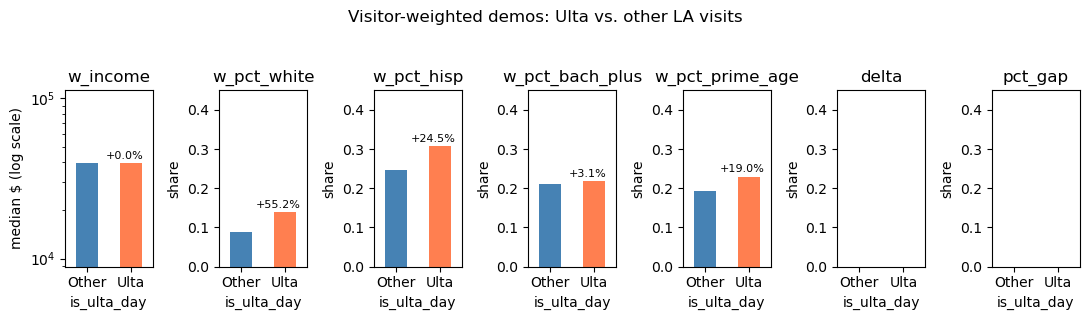

In [29]:
# ▸ metric-centric gap table  + quick visual  ──────────────────────────────
import matplotlib.pyplot as plt

# 1 ── pivot: rows = metrics, cols = Other / Ulta
gap = (demo_cmp.T                    # metrics as rows
         .rename(columns={'non-Ulta days': 'Other',
                          'Ulta days'     : 'Ulta'}))

# 2 ── absolute & relative gaps
gap['Δ']       = gap['Ulta'] - gap['Other']
gap['%_gap']   = gap['Δ'] / gap['Other']

display(gap.round(3))

# 3 ── side-by-side bars (log $ axis for income so ranges line up)
fig, axes = plt.subplots(1, len(gap), figsize=(11,3), sharey=False)

for ax, (metric, row) in zip(axes, gap.iterrows()):
    row[['Other','Ulta']].plot.bar(ax=ax, rot=0, color=['steelblue','coral'])
    ax.set_title(metric)
    if metric == 'w_income':
        ax.set_yscale('log')
        ax.set_ylabel('median $ (log scale)')
    else:
        ax.set_ylim(0, 0.45)
        ax.set_ylabel('share')
    # annotate Δ or %_gap above Ulta bar
    ax.annotate(f"{row['%_gap']:+.1%}",
                xy=(0.85, row['Ulta']), xytext=(0,3),
                textcoords='offset points', ha='center', fontsize=8)

fig.suptitle('Visitor-weighted demos: Ulta vs. other LA visits', y=1.05)
plt.tight_layout(); plt.show()


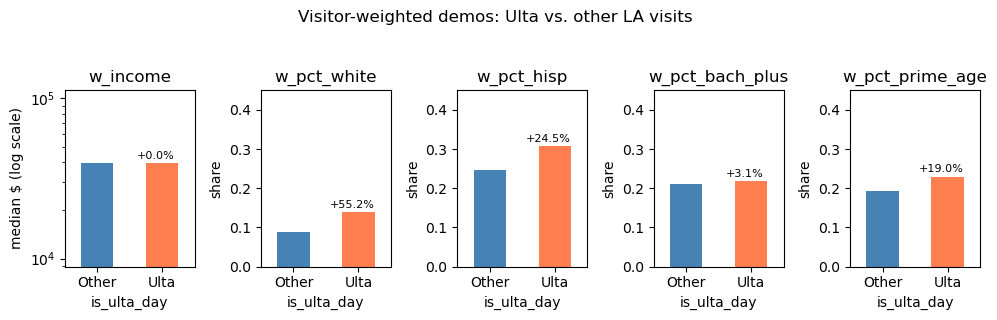

In [30]:
# ▸ remove the helper rows and rebuild the chart ────────────────────────────
clean_gap = (gap                      # gap from previous cell
               .loc[~gap.index.isin(['delta','pct_gap'])]     # or  gap.dropna(how='all')
               .copy())

fig, axes = plt.subplots(1, len(clean_gap), figsize=(10,3), sharey=False)

for ax, (metric, row) in zip(axes, clean_gap.iterrows()):
    row[['Other','Ulta']].plot.bar(ax=ax, rot=0,
                                   color=['steelblue','coral'])
    ax.set_title(metric)
    if metric == 'w_income':
        ax.set_yscale('log')
        ax.set_ylabel('median $ (log scale)')
    else:
        ax.set_ylim(0, 0.45)
        ax.set_ylabel('share')
    ax.annotate(f"{row['%_gap']:+.1%}",
                xy=(0.9, row['Ulta']), xytext=(0,3),
                textcoords='offset points', ha='center', fontsize=8)

fig.suptitle('Visitor-weighted demos: Ulta vs. other LA visits', y=1.05)
plt.tight_layout(); plt.show()


In [31]:
# helper: weighted-median demo for any brand
def brand_demo(df, brand):
    mask = df['related_brands'].apply(lambda L: brand in L)
    return df.loc[mask, [
        'w_income', 'w_pct_white', 'w_pct_hisp',
        'w_pct_bach_plus', 'w_pct_prime_age'
    ]].median()

# Ulta baseline (5-dimensional)
ulta_vec = brand_demo(df, ulta_token)

rows = []
for _, r in rules.iterrows():                         # 'rules' already has lift residuals
    b          = r['other_brand']
    demo_vec   = brand_demo(df, b)
    # scale each dimension so \$ and % are comparable
    v = np.array([
        (demo_vec['w_income']        - ulta_vec['w_income'])        / 1e3,   # \$-scale
        (demo_vec['w_pct_white']     - ulta_vec['w_pct_white'])     * 100,
        (demo_vec['w_pct_hisp']      - ulta_vec['w_pct_hisp'])      * 100,
        (demo_vec['w_pct_bach_plus'] - ulta_vec['w_pct_bach_plus']) * 100,
        (demo_vec['w_pct_prime_age'] - ulta_vec['w_pct_prime_age']) * 100,
    ])
    rows.append({
        'brand'        : b,
        'lift'         : r['lift'],
        'lift_resid'   : r['residual'],
        'distance_mi'  : r['min_distance_miles'],
        'demo_gap'     : np.linalg.norm(v)            # 5-D Euclidean gap
    })

all_brands = pd.DataFrame(rows)


In [32]:
watch = (all_brands
           .assign(
               fit_score = lambda t:
                   t['lift_resid'].rank(ascending=False) +   # ↑ better
                   t['demo_gap'] .rank(ascending=True)       # ↓ better
           )
           .sort_values('fit_score')
           .reset_index(drop=True))

watch.to_csv('../Data/ulta_partner_watchlist_v2.csv', index=False)
print("✅  wrote updated watch-list with 5-dim trait match → ulta_partner_watchlist_v2.csv")
display(watch.head(10))


✅  wrote updated watch-list with 5-dim trait match → ulta_partner_watchlist_v2.csv


,brand,lift,lift_resid,distance_mi,demo_gap,fit_score
0,Seafood City,238.559479,2.899698,0.071923,8.654667,33.5
1,PetSmart,184.726057,2.644634,0.080111,8.654667,34.5
2,Fitness 19,143.977662,2.395480,0.080861,8.654667,35.5
3,Cotton On,106.352215,2.217795,1.586904,8.654667,36.5
4,Western Dental,95.325417,1.984094,0.092594,8.654667,37.5
5,Chuck E. Cheese's,67.427555,1.634864,0.056659,8.654667,38.5
6,Swarovski,53.886376,1.532459,1.521268,8.654667,39.5
7,Lowe's,58.276673,1.491417,0.085589,8.654667,40.5
8,Spectrum,54.614477,1.438559,0.230461,8.654667,41.5
9,GameStop,54.391561,1.420605,0.063705,8.654667,42.5


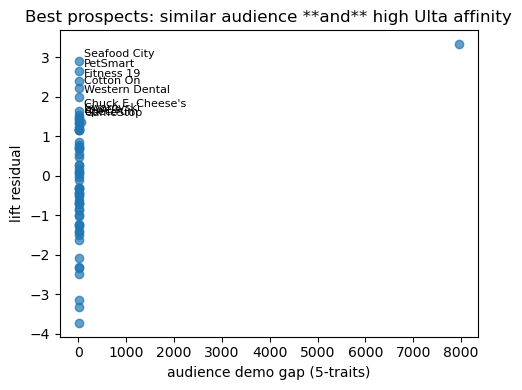

In [33]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(watch['demo_gap'], watch['lift_resid'], alpha=0.7)
for _, r in watch.head(10).iterrows():
    ax.annotate(r['brand'], (r['demo_gap'], r['lift_resid']),
                xytext=(4,3), textcoords='offset points', fontsize=8)

ax.set_xlabel('audience demo gap (5-traits)')
ax.set_ylabel('lift residual')
ax.set_title('Best prospects: similar audience **and** high Ulta affinity')
plt.tight_layout(); plt.show()


In [37]:
import pandas as pd, numpy as np, statsmodels.api as sm

# ---------------------------------------------------------------
# 0 ▸ load rules + make SURE a `lift_resid` column exists
# ---------------------------------------------------------------
rules = pd.read_csv("../Data/ulta_rules_with_distance.csv")

cols = rules.columns

if "lift_resid" in cols:
    pass                                            # already good
elif "residual" in cols:
    rules = rules.rename(columns={"residual": "lift_resid"})
else:
    # (re)build it: log-linear model  log(lift) ~ distance
    rules = rules.dropna(subset=["min_distance_miles"])
    rules = rules[rules["lift"] > 0]                # avoid log(0)
    rules["log_lift"] = np.log(rules["lift"])

    X = sm.add_constant(rules["min_distance_miles"])
    beta = sm.OLS(rules["log_lift"], X).fit().predict(X)   # predicted log-lift
    rules["lift_resid"] = rules["log_lift"] - beta         # surprise above trend
    # keep table tidy
    rules = rules.drop(columns=["log_lift"])

# quick sanity check
assert "lift_resid" in rules.columns, "still missing lift_resid!"

# ---------------------------------------------------------------
# … now continue exactly as before
# ---------------------------------------------------------------
DEMO_COLS = ['w_income', 'w_pct_white', 'w_pct_hisp',
             'w_pct_bach_plus', 'w_pct_prime_age']

brand_vecs = {b: df.loc[df['related_brands'].apply(lambda L: b in L),
                        DEMO_COLS].median()
              for b in rules['other_brand'].unique()}

ulta_vec             = df.loc[ulta_mask, DEMO_COLS].median()
demo_df              = pd.DataFrame(brand_vecs).T
demo_df.loc['Ulta']  = ulta_vec                     # pandas-2 safe

from sklearn.preprocessing import StandardScaler
scaler   = StandardScaler().fit(demo_df)
demo_z   = pd.DataFrame(scaler.transform(demo_df),
                        index=demo_df.index,
                        columns=DEMO_COLS)

demo_gap = ((demo_z.drop('Ulta') - demo_z.loc['Ulta'])**2)\
             .sum(axis=1).pow(0.5)                 # √∑(Δ²)

# build watch-list
watch = (rules.merge(demo_gap.rename('demo_gap'),
                     left_on='other_brand',
                     right_index=True)
               .assign(fit_score=lambda t:
                       t['lift_resid'].rank(ascending=False) +
                       t['demo_gap'] .rank(ascending=True))
               .sort_values('fit_score')
               .rename(columns={'other_brand':'brand',
                                'min_distance_miles':'distance_mi'})
               [['brand','lift','lift_resid','distance_mi',
                 'demo_gap','fit_score']]
               .reset_index(drop=True))

watch.to_csv("../Data/ulta_partner_watchlist_v3.csv", index=False)
print("✅  wrote updated watch-list → ../Data/ulta_partner_watchlist_v3.csv")
display(watch.head(10))


✅  wrote updated watch-list → ../Data/ulta_partner_watchlist_v3.csv


,brand,lift,lift_resid,distance_mi,demo_gap,fit_score
0,Seafood City,238.559479,2.899698,0.071923,2.973351,33.5
1,PetSmart,184.726057,2.644634,0.080111,2.973351,34.5
2,Fitness 19,143.977662,2.395480,0.080861,2.973351,35.5
3,Cotton On,106.352215,2.217795,1.586904,2.973351,36.5
4,Western Dental,95.325417,1.984094,0.092594,2.973351,37.5
5,Chuck E. Cheese's,67.427555,1.634864,0.056659,2.973351,38.5
6,Swarovski,53.886376,1.532459,1.521268,2.973351,39.5
7,Lowe's,58.276673,1.491417,0.085589,2.973351,40.5
8,Spectrum,54.614477,1.438559,0.230461,2.973351,41.5
9,GameStop,54.391561,1.420605,0.063705,2.973351,42.5


In [39]:
# ⬆ keep everything ABOVE here exactly the same …
# ------------------------------------------------
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# partner clusters – colour palette  (replace the old line)
cmap     = cm.get_cmap('Set2', len(watch))          # Brewer Set2 with N distinct hues
palette  = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, b in enumerate(watch['brand']):
    brand_cluster = MarkerCluster(name=b).add_to(m)
    rows  = partner_poi[partner_poi['category'] == b]
    resid = watch.loc[watch['brand'] == b, 'lift_resid'].iloc[0]
    for _, r in rows.iterrows():
        folium.CircleMarker(
            location=(r['latitude'], r['longitude']),
            radius=6 + 3*np.log1p(resid),
            color=palette[i],
            fill=True, fill_opacity=0.7,
            popup=f"{b}<br>lift resid: {resid:,.2f}"
        ).add_to(brand_cluster)

folium.LayerControl().add_to(m)
m.save(MAP_PATH)
print(f"✅  Inter­active map written → {MAP_PATH}")


✅  Inter­active map written → ../Data/ulta_partner_map.html


/var/folders/qg/lwhfngzd7tggvg4lhl92prj80000gn/T/ipykernel_96425/1276679841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap     = cm.get_cmap('Set2', len(watch))          # Brewer Set2 with N distinct hues


In [44]:
# ── peek at the raw counts feeding the lift calc ───────────────────────────
partners  = watch['brand'].head(10)
vis_date  = pd.to_datetime(df['date_range_start']).dt.normalize()
df['visit_date'] = vis_date                         # cache once

for b in partners:
    both_cnt   = df[df['related_brands'].apply(lambda L: ulta_token in L and b in L)] \
                   .groupby('visit_date').size()
    ulta_cnt   = df[ulta_mask].groupby('visit_date').size()
    brand_cnt  = df[df['related_brands'].apply(lambda L: b in L)] \
                   .groupby('visit_date').size()
    total_cnt  = df.groupby('visit_date').size()

    peek = pd.DataFrame({
        'both':  both_cnt,
        'ulta':  ulta_cnt,
        'brand': brand_cnt,
        'total': total_cnt
    }).fillna(0).astype(int)

    print(f"\n── {b} ─────────────────────────────")
    display(peek)



── Seafood City ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,25,237,57,128908



── PetSmart ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,36,237,106,128908



── Fitness 19 ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,27,237,102,128908



── Cotton On ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,35,237,179,128908



── Western Dental ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,17,237,97,128908



── Chuck E. Cheese's ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,30,237,242,128908



── Swarovski ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,32,237,323,128908



── Lowe's ─────────────────────────────


,both,ulta,brand,total
visit_date,,,,
2024-03-18 00:00:00+00:00,15,237,140,128908


In [46]:
import numpy as np, pandas as pd

partners = watch['brand'].head(100)        # the 10 shortlisted brands
rows     = []

for b in partners:
    both_rows  = df[df['related_brands'].apply(lambda L: ulta_token in L and b in L)]
    ulta_rows  = df[ulta_mask]
    brand_rows = df[df['related_brands'].apply(lambda L: b in L)]

    P_b_given_ulta = len(both_rows)  / len(ulta_rows)   if len(ulta_rows)  else np.nan
    P_b_overall    = len(brand_rows) / len(df)          if len(df)        else np.nan
    lift           = P_b_given_ulta / P_b_overall       if P_b_overall   else np.nan

    rows.append({"brand": b, "co_visit_lift": lift,
                 "co_visits": len(both_rows),
                 "ulta_visits": len(ulta_rows),
                 "brand_visits": len(brand_rows)})

day_lift = pd.DataFrame(rows).sort_values('co_visit_lift', ascending=False)
display(day_lift)


,brand,co_visit_lift,co_visits,ulta_visits,brand_visits
0,Seafood City,238.559479,25,237,57
1,PetSmart,184.726057,36,237,106
2,Fitness 19,143.977662,27,237,102
3,Cotton On,106.352215,35,237,179
4,Western Dental,95.325417,17,237,97
5,Chuck E. Cheese's,67.427555,30,237,242
7,Lowe's,58.276673,15,237,140
6,Swarovski,53.886376,32,237,323


In [47]:
# %%  ── FINAL STEP: persist the enriched dataset for Streamlit ─────────────
# (place this cell AFTER everything else)

SAVE_PATH = "../Data/la_foot_traffic_enriched.parquet"

# drop heavy/Arrow-unfriendly object columns that we don't need in the dashboard
tidy_df = df.drop(columns=['cbg_pairs', 'home_cbgs_dict'], errors='ignore')

tidy_df.to_parquet(SAVE_PATH, index=False)
print(f"💾  Saved updated enriched parquet with 5-dim demos → {SAVE_PATH}")

# quick sniff – first 3 rows of the new demographic fields
display(
    tidy_df[
        ['w_income', 'w_pct_white', 'w_pct_hisp',
         'w_pct_bach_plus', 'w_pct_prime_age']
    ].head(3)
)


💾  Saved updated enriched parquet with 5-dim demos → ../Data/la_foot_traffic_enriched.parquet


,w_income,w_pct_white,w_pct_hisp,w_pct_bach_plus,w_pct_prime_age
NaN,39330.514035,0.08943,0.246628,0.211644,0.192932
NaN,39330.514035,0.08943,0.246628,0.211644,0.192932
NaN,39330.514035,0.08943,0.246628,0.211644,0.192932
